<a href="https://colab.research.google.com/github/Elango-Natarajan/PredatorFree_Hakarimata_2025/blob/main/Greg_dataclean_visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# Install dependencies (run this cell once in Colab)
!sudo apt-get install tesseract-ocr
!pip install pytesseract pillow pandas

# Image upload for Colab
from google.colab import files
uploaded = files.upload()

import re
from PIL import Image
import pytesseract
import pandas as pd

def extract_overlay_text(img_path):
    # Crop the bottom part of the image where the overlay is (adjust if needed)
    with Image.open(img_path) as img:
        width, height = img.size
        # Try a larger crop for overlays (change height as needed)
        overlay = img.crop((0, height - 140, width, height))
        overlay = overlay.convert('L')  # Grayscale for better OCR
        text = pytesseract.image_to_string(overlay)
    return text

def parse_overlay(text):
    line = ' '.join(text.split())
    # Main regex for robust extraction
    pattern = r"(\d+\.\d+)\s*in\w+\W*\s*(\d{1,2})[^\d]*(?:\d{2,3})?[A-Za-z]*\s*(\d{2}/\d{2}/\d{4})(?:\s*(\d{1,2}:\d{2}[AP]M))?.*?(CAMERA\S*)"
    match = re.search(pattern, line)
    if match:
        pressure = match.group(1)
        temperature = match.group(2)
        date = match.group(3)
        time = match.group(4) if match.group(4) else ""
        camera = match.group(5)
        return {
            'pressure': pressure,
            'temperature': temperature,
            'date': date,
            'time': time,
            'camera': camera
        }
    # Fallback block-wise extraction
    pressure_match = re.search(r"(\d+\.\d+)", line)
    pressure = pressure_match.group(1) if pressure_match else ""
    after_inhg = re.split(r"in\w+\W*", line, maxsplit=1)
    temperature = ""
    if len(after_inhg) > 1:
        temp_match = re.search(r"(\d{1,2})", after_inhg[1])
        if temp_match:
            temperature = temp_match.group(1)
    date_match = re.search(r"(\d{2}/\d{2}/\d{4})", line)
    date = date_match.group(1) if date_match else ""
    time_match = re.search(r"(\d{1,2}:\d{2}[AP]M)", line)
    time = time_match.group(1) if time_match else ""
    camera_match = re.search(r"(CAMERA\S*)", line)
    camera = camera_match.group(1) if camera_match else ""
    return {
        'pressure': pressure,
        'temperature': temperature,
        'date': date,
        'time': time,
        'camera': camera
    }

# Process all uploaded images
meta_list = []
for filename in uploaded.keys():
    overlay_text = extract_overlay_text(filename)
    meta = parse_overlay(overlay_text)
    meta['filename'] = filename
    meta_list.append(meta)

# Save to CSV
df = pd.DataFrame(meta_list)
df.to_csv('overlay_metadata_output.csv', index=False)
print("Saved as overlay_metadata_output.csv")

# Download the CSV
files.download('overlay_metadata_output.csv')

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

# Load your metadata file
df = pd.read_csv('/content/sample_data/Greg_October_metadata.csv')

# ---- Temperature Cleaning ----
def clean_temperature(temp):
    if pd.isnull(temp) or temp == '':
        return ''
    temp_str = str(temp)
    match = re.match(r'(\d+)', temp_str)
    if match:
        temp_val = int(match.group(1))
        if temp_val > 40:
            return int(str(temp_val)[0])
        return temp_val
    return ''

df['temperature'] = df['temperature'].apply(clean_temperature)

# ---- Camera Name Cleaning ----
def clean_camera(cam):
    if pd.isnull(cam):
        return ''
    cam_str = str(cam)
    match = re.search(r'(CAMERA\d+)', cam_str)
    if match:
        return match.group(1)
    else:
        if 'CAMERA' in cam_str:
            return 'CAMERA'
    return ''

df['camera'] = df['camera'].apply(clean_camera)

# ---- Pressure Cleaning ----
def clean_pressure(p):
    if pd.isnull(p) or p == '':
        return ''
    try:
        return float(p)
    except:
        match = re.search(r'(\d+\.\d+)', str(p))
        if match:
            return float(match.group(1))
        return ''

df['pressure'] = df['pressure'].apply(clean_pressure)

# ---- Fill Missing Data ----
df = df.sort_values(['date', 'time', 'camera', 'filename'])
df['pressure'] = df.groupby(['date', 'time', 'camera'])['pressure'].ffill().bfill()
df['temperature'] = df.groupby(['date', 'time', 'camera'])['temperature'].ffill().bfill()

# ---- Temporal Columns ----
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], errors='coerce')
df['hour'] = pd.to_datetime(df['time'], format='%I:%M%p', errors='coerce').dt.hour

# ---- Save cleaned CSV ----
df.to_csv('Greg_October_metadata_cleaned.csv', index=False)
print("Cleaned metadata saved to Greg_October_metadata_cleaned.csv")

Cleaned metadata saved to Greg_October_metadata_cleaned.csv


/tmp/ipython-input-280508354.py:57: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['temperature'] = df.groupby(['date', 'time', 'camera'])['temperature'].ffill().bfill()
/tmp/ipython-input-280508354.py:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], errors='coerce')



Pressure stats:
count     123.00
unique     14.00
top        29.94
freq       28.00
Name: pressure, dtype: float64

Temperature stats:
count    123.000000
mean       8.707317
std        1.265764
min        8.000000
25%        8.000000
50%        8.000000
75%        9.000000
max       12.000000
Name: temperature, dtype: float64


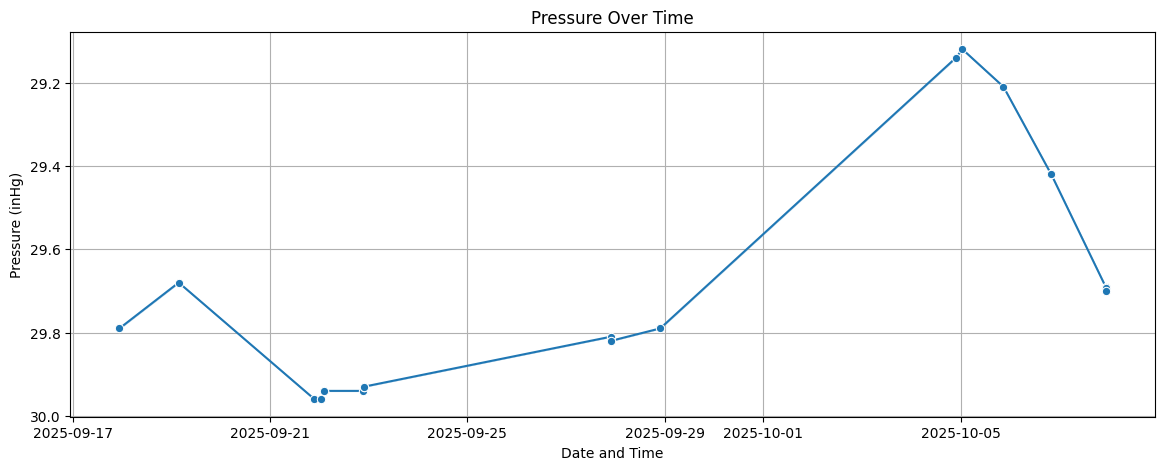

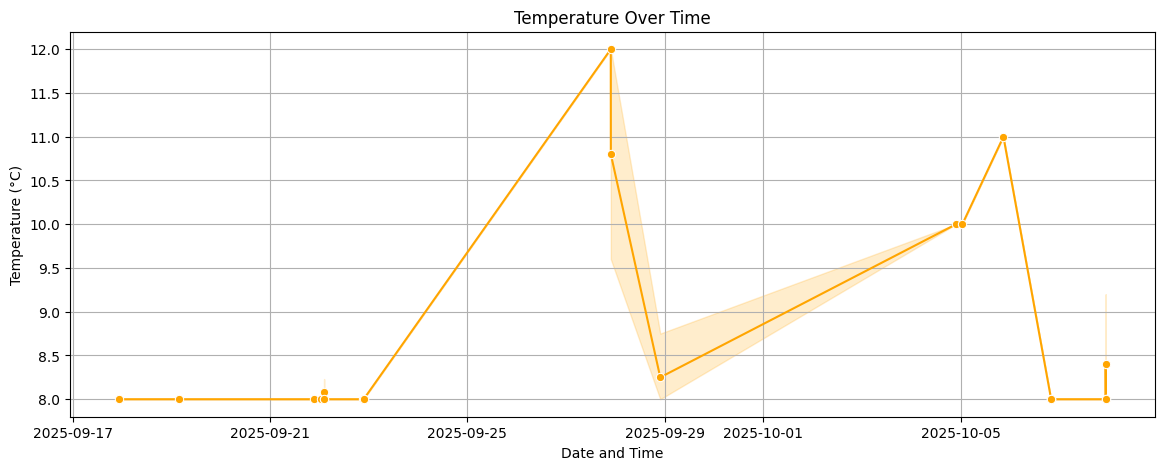

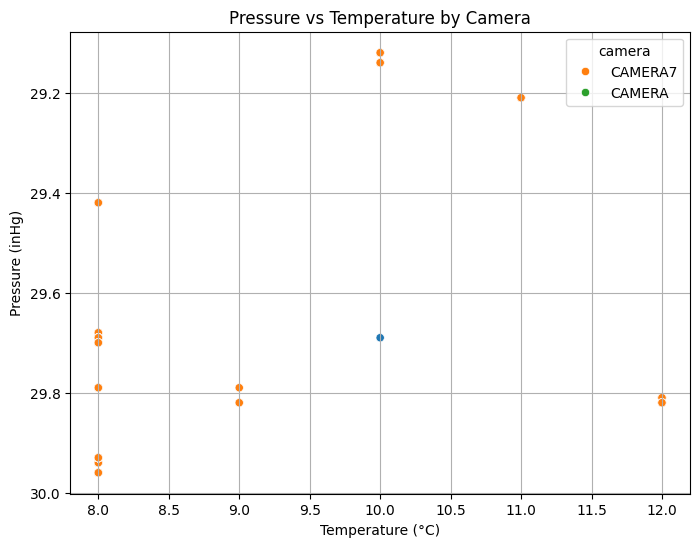

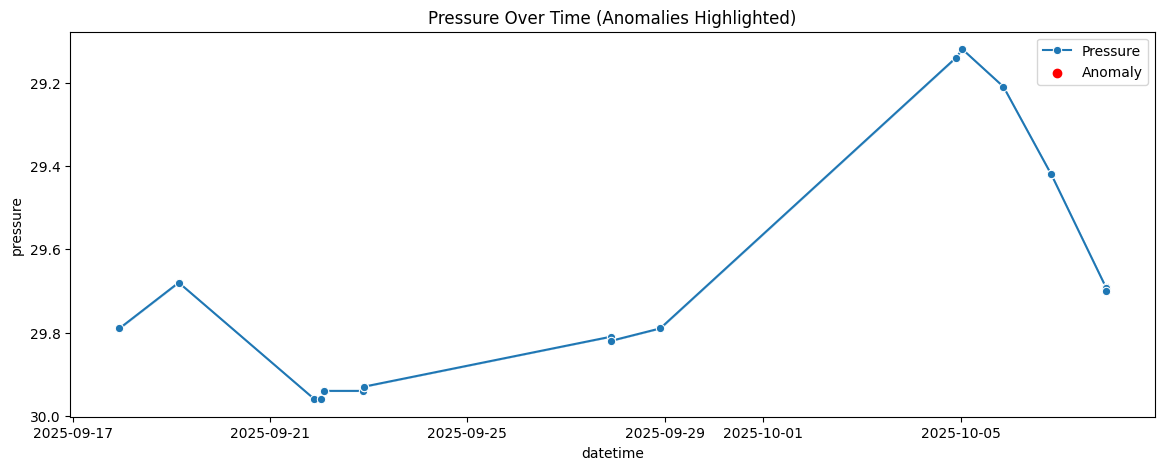

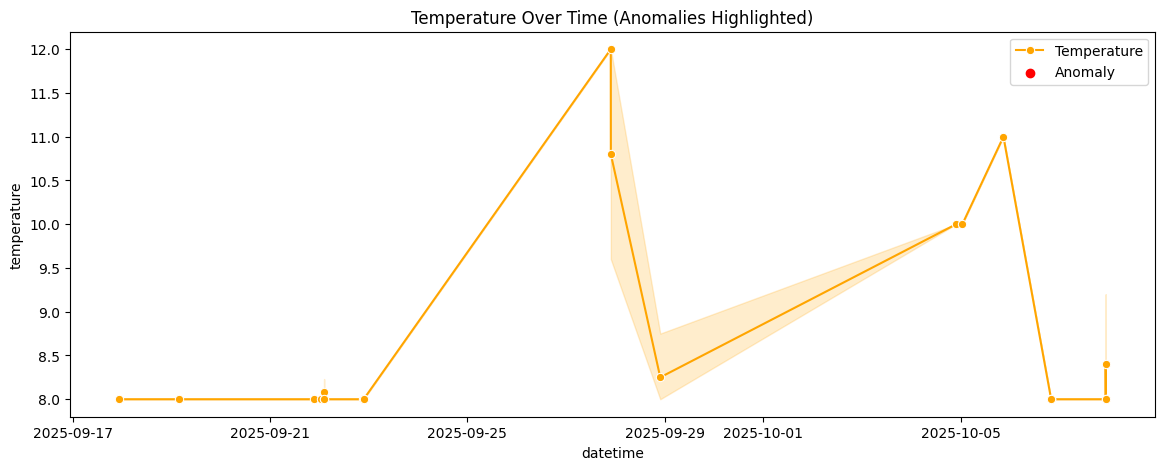

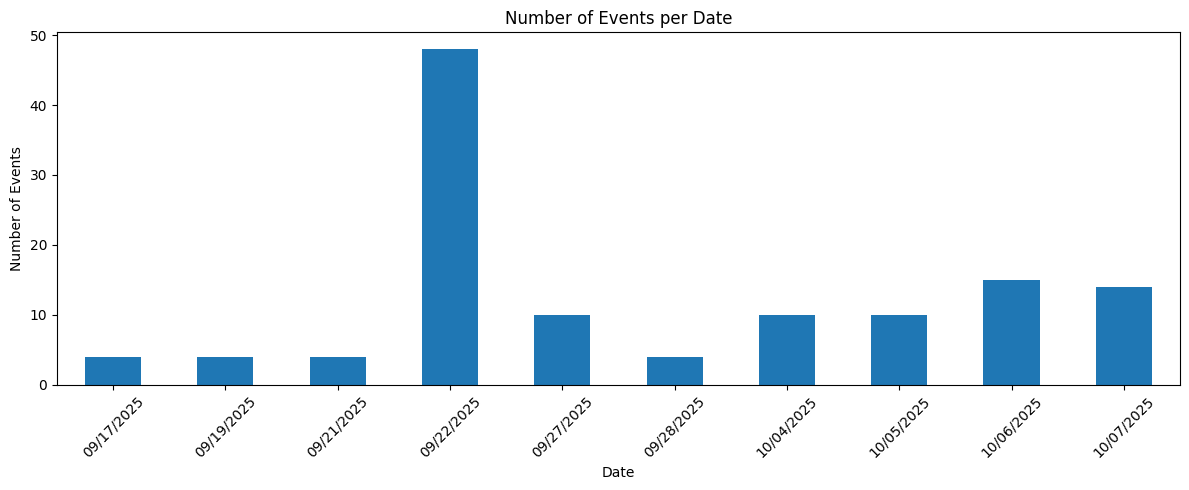

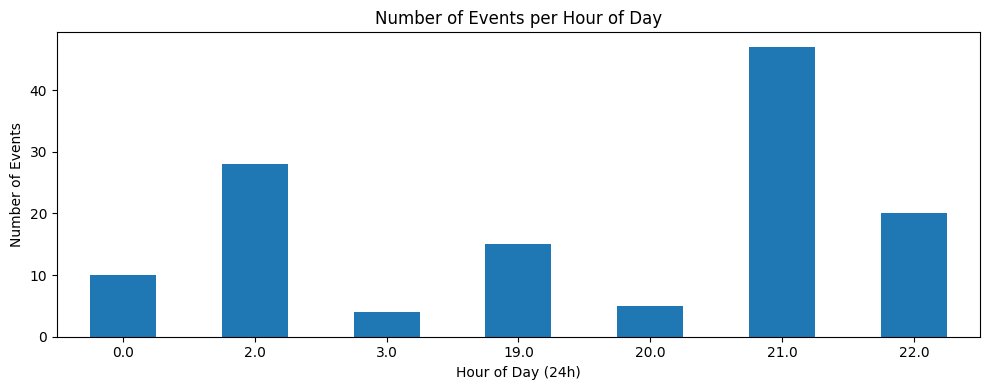

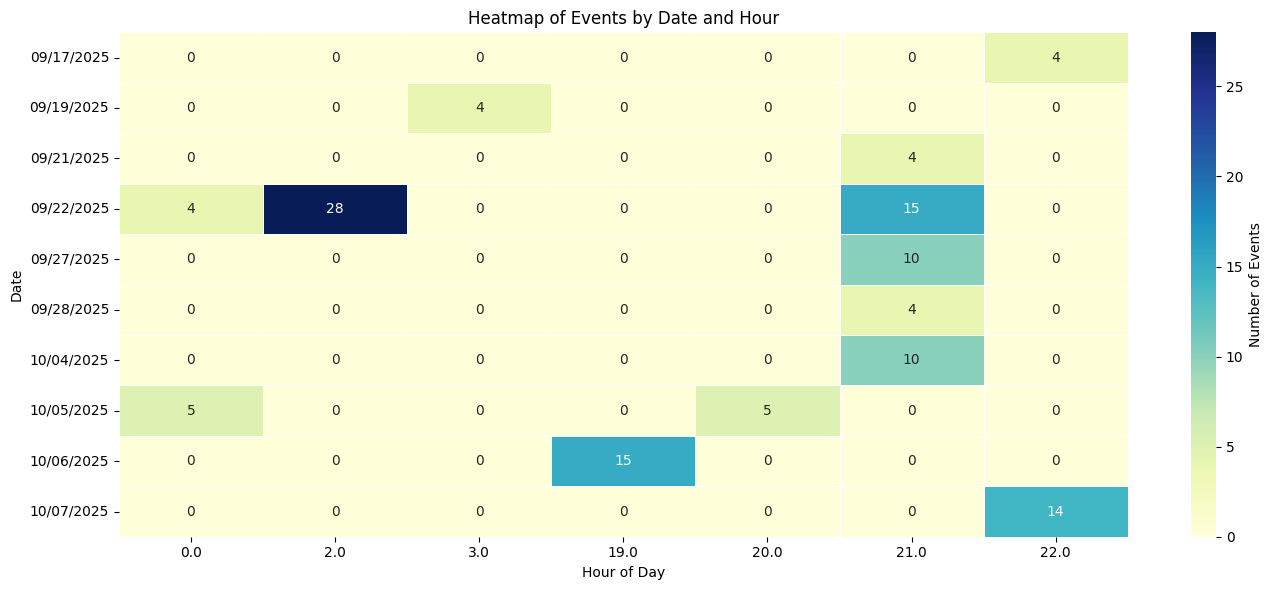

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# ---- Descriptive Statistics ----
print("\nPressure stats:")
print(df['pressure'].describe())
print("\nTemperature stats:")
print(df['temperature'].describe())

# ---- Patterns and Anomalies Visualization ----
plt.figure(figsize=(14,5))
sns.lineplot(x='datetime', y='pressure', data=df, marker='o')
plt.title('Pressure Over Time')
plt.ylabel('Pressure (inHg)')
plt.xlabel('Date and Time')
plt.grid(True)
plt.show()

plt.figure(figsize=(14,5))
sns.lineplot(x='datetime', y='temperature', data=df, marker='o', color='orange')
plt.title('Temperature Over Time')
plt.ylabel('Temperature (°C)')
plt.xlabel('Date and Time')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x='temperature', y='pressure', data=df, hue='camera', palette='tab10')
plt.title('Pressure vs Temperature by Camera')
plt.xlabel('Temperature (°C)')
plt.ylabel('Pressure (inHg)')
plt.grid(True)
plt.show()

# ---- Anomaly Detection (Z-score) ----
def detect_outliers(series, threshold=3):
    # Convert the series to numeric, coercing errors to NaN
    numeric_series = pd.to_numeric(series, errors='coerce')
    # Drop NaN values before calculating mean and std
    numeric_series_cleaned = numeric_series.dropna()
    if len(numeric_series_cleaned) < 2:  # Handle cases with fewer than 2 non-NaN values
        return pd.Series(False, index=series.index)
    z = (numeric_series_cleaned - numeric_series_cleaned.mean()) / numeric_series_cleaned.std()
    return np.abs(z) > threshold

pressure_outliers = detect_outliers(df['pressure'])
temperature_outliers = detect_outliers(df['temperature'])


plt.figure(figsize=(14,5))
sns.lineplot(x='datetime', y='pressure', data=df, marker='o', label='Pressure')
outlier_points = df.loc[pressure_outliers[pressure_outliers].index, ['datetime','pressure']]
plt.scatter(outlier_points['datetime'], outlier_points['pressure'], color='red', label='Anomaly', zorder=5)
plt.title('Pressure Over Time (Anomalies Highlighted)')
plt.legend()
plt.show()

plt.figure(figsize=(14,5))
sns.lineplot(x='datetime', y='temperature', data=df, marker='o', color='orange', label='Temperature')
outlier_points = df.loc[temperature_outliers[temperature_outliers].index, ['datetime','temperature']]
plt.scatter(outlier_points['datetime'], outlier_points['temperature'], color='red', label='Anomaly', zorder=5)
plt.title('Temperature Over Time (Anomalies Highlighted)')
plt.legend()
plt.show()

# ---- Events per Date ----
events_per_date = df['date'].value_counts().sort_index()
plt.figure(figsize=(12,5))
events_per_date.plot(kind='bar')
plt.title('Number of Events per Date')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---- Events per Hour of Day ----
events_per_hour = df['hour'].value_counts().sort_index()
plt.figure(figsize=(10,4))
events_per_hour.plot(kind='bar')
plt.title('Number of Events per Hour of Day')
plt.xlabel('Hour of Day (24h)')
plt.ylabel('Number of Events')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# ---- Heatmap of Events by Date and Hour ----
heatmap_data = df.groupby([df['date'], 'hour']).size().unstack(fill_value=0)
plt.figure(figsize=(14,6))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=.5, annot=True, fmt='d', cbar_kws={'label': 'Number of Events'})
plt.title('Heatmap of Events by Date and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Date')
plt.tight_layout()
plt.savefig('greg_heatmap_events_date_hour.png', dpi=300)
plt.show()

# ---- (Colab) Download the exported heatmap ----
try:
    from google.colab import files
    files.download('greg_heatmap_events_date_hour.png')
except ImportError:
    print("If running locally: check the working directory for 'greg_heatmap_events_date_hour.png'.")

In [9]:
!pip install ephem
import pandas as pd
import ephem
from datetime import datetime

# Load your cleaned data (replace with your filename)
df = pd.read_csv('Greg_October_metadata_cleaned.csv')

# Parse date
df['date_obj'] = pd.to_datetime(df['date'], errors='coerce')

def lunar_phase(dt):
    """Return the moon phase name for a given date."""
    if pd.isnull(dt): return None
    moon = ephem.Moon()
    obs = ephem.Observer()
    obs.date = dt
    moon.compute(obs)
    phase = moon.phase  # 0=new, 7=first quarter, 14=full, 21=last quarter
    if phase < 3:
        return 'New Moon'
    elif 3 <= phase < 7:
        return 'Waxing Crescent'
    elif 7 <= phase < 10:
        return 'First Quarter'
    elif 10 <= phase < 14:
        return 'Waxing Gibbous'
    elif 14 <= phase < 17:
        return 'Full Moon'
    elif 17 <= phase < 21:
        return 'Waning Gibbous'
    elif 21 <= phase < 24:
        return 'Last Quarter'
    else:
        return 'Waning Crescent'

df['lunar_phase'] = df['date_obj'].apply(lunar_phase)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.1 MB/s eta 0:00:00


/tmp/ipython-input-1380253594.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=phase_counts.index, y=phase_counts.values, palette='Blues')


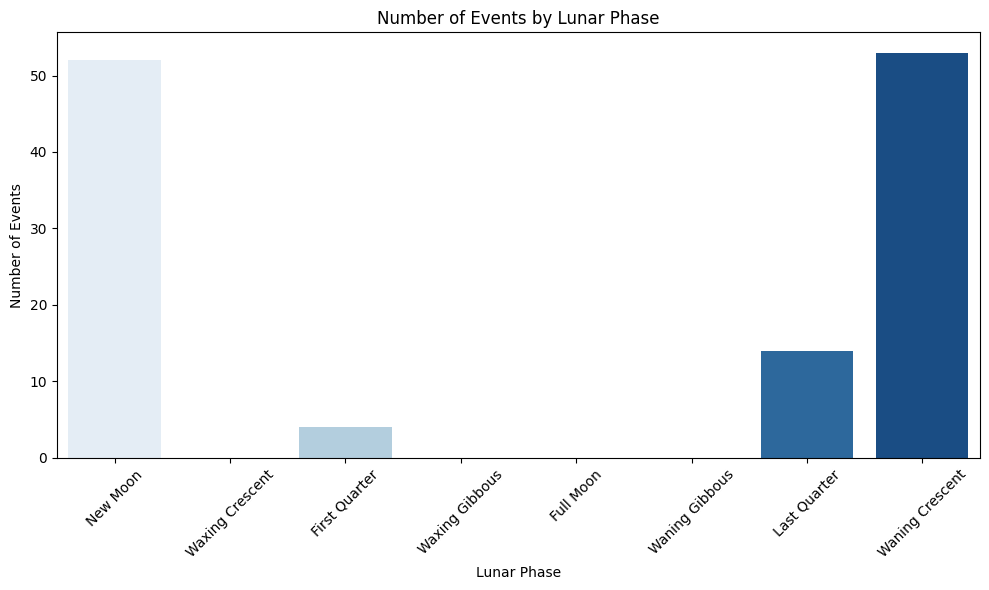

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count events by lunar phase
phase_counts = df['lunar_phase'].value_counts().reindex([
    'New Moon', 'Waxing Crescent', 'First Quarter', 'Waxing Gibbous',
    'Full Moon', 'Waning Gibbous', 'Last Quarter', 'Waning Crescent'
])

plt.figure(figsize=(10,6))
sns.barplot(x=phase_counts.index, y=phase_counts.values, palette='Blues')
plt.title('Number of Events by Lunar Phase')
plt.xlabel('Lunar Phase')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

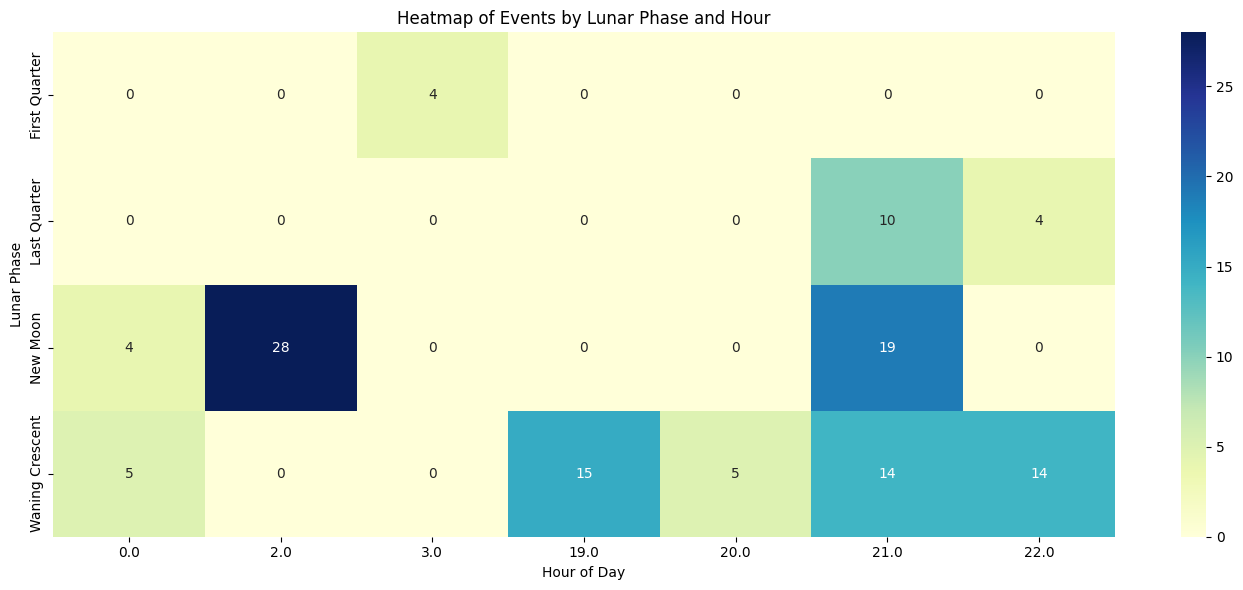

In [11]:
# Example: Events per hour for each lunar phase
pivot = pd.pivot_table(df, index='lunar_phase', columns='hour', values='filename', aggfunc='count', fill_value=0)
plt.figure(figsize=(14,6))
sns.heatmap(pivot, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap of Events by Lunar Phase and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Lunar Phase')
plt.tight_layout()
plt.show()

/tmp/ipython-input-3660689714.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=phase_counts.index, y=phase_counts.values, palette='Blues')


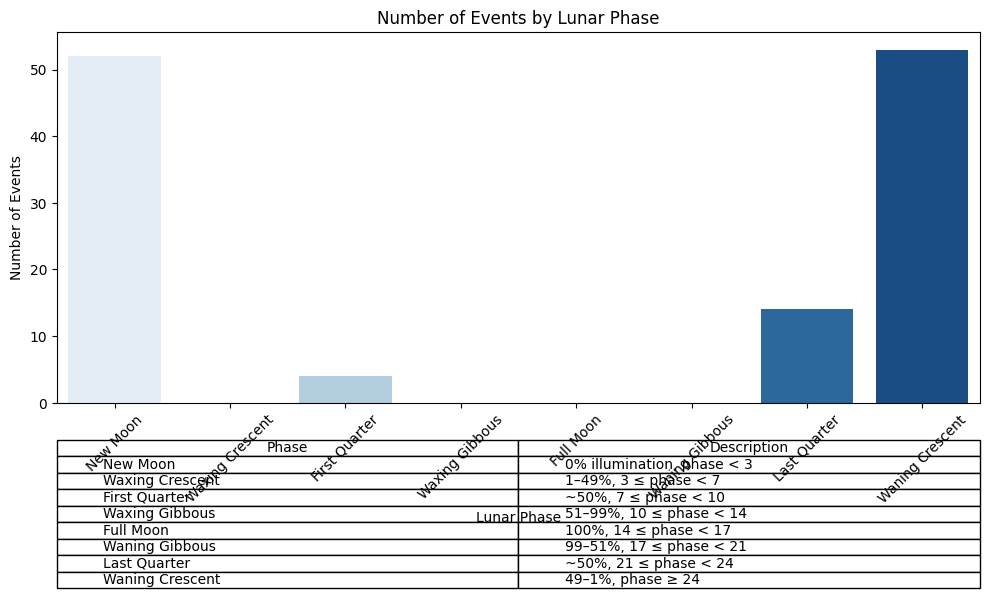

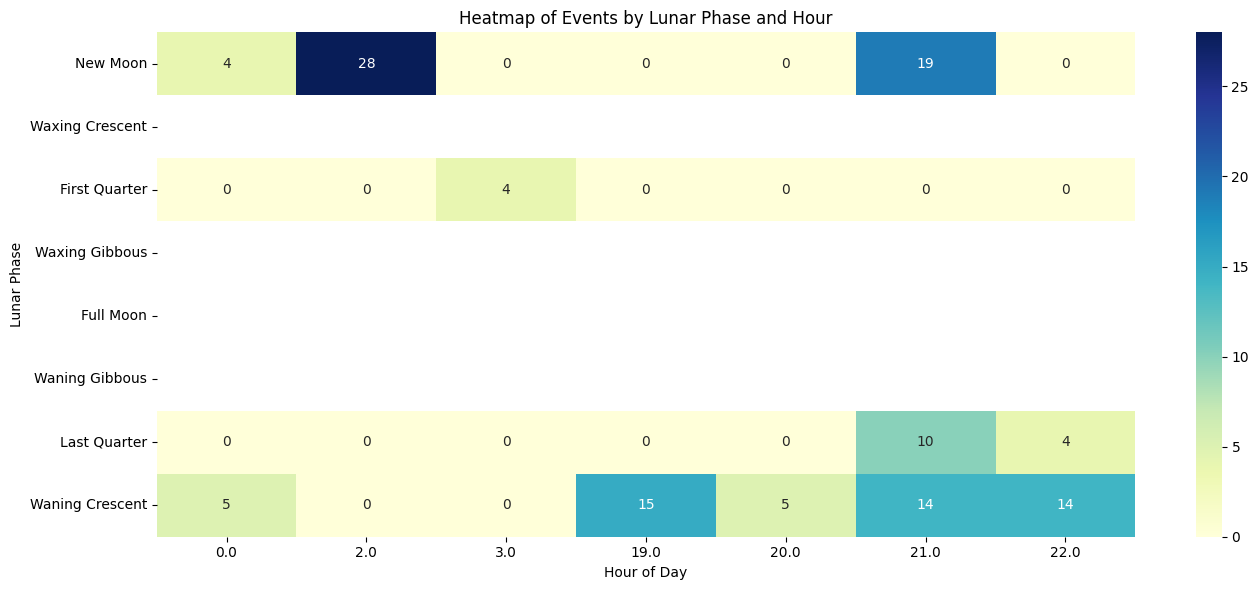

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ephem

# Load your cleaned metadata
df = pd.read_csv('Greg_October_metadata_cleaned.csv')

# Parse date and extract hour from time
df['date_obj'] = pd.to_datetime(df['date'], errors='coerce')
df['hour'] = pd.to_datetime(df['time'], format='%I:%M%p', errors='coerce').dt.hour

# Lunar phase function
def lunar_phase(dt):
    if pd.isnull(dt):
        return None
    moon = ephem.Moon()
    obs = ephem.Observer()
    obs.date = dt
    moon.compute(obs)
    phase = moon.phase
    if phase < 3:
        return 'New Moon'
    elif 3 <= phase < 7:
        return 'Waxing Crescent'
    elif 7 <= phase < 10:
        return 'First Quarter'
    elif 10 <= phase < 14:
        return 'Waxing Gibbous'
    elif 14 <= phase < 17:
        return 'Full Moon'
    elif 17 <= phase < 21:
        return 'Waning Gibbous'
    elif 21 <= phase < 24:
        return 'Last Quarter'
    else:
        return 'Waning Crescent'

# Annotate lunar phase
df['lunar_phase'] = df['date_obj'].apply(lunar_phase)

# Define lunar phase order for plotting
lunar_phase_order = [
    'New Moon', 'Waxing Crescent', 'First Quarter', 'Waxing Gibbous',
    'Full Moon', 'Waning Gibbous', 'Last Quarter', 'Waning Crescent'
]

# Bar plot: Number of events by lunar phase
phase_counts = df['lunar_phase'].value_counts().reindex(lunar_phase_order)
plt.figure(figsize=(10,6))
sns.barplot(x=phase_counts.index, y=phase_counts.values, palette='Blues')
plt.title('Number of Events by Lunar Phase')
plt.xlabel('Lunar Phase')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.tight_layout()

# Add lunar phase legend as a table on the plot
legend_data = [
    ('New Moon', '0% illumination, phase < 3'),
    ('Waxing Crescent', '1–49%, 3 ≤ phase < 7'),
    ('First Quarter', '~50%, 7 ≤ phase < 10'),
    ('Waxing Gibbous', '51–99%, 10 ≤ phase < 14'),
    ('Full Moon', '100%, 14 ≤ phase < 17'),
    ('Waning Gibbous', '99–51%, 17 ≤ phase < 21'),
    ('Last Quarter', '~50%, 21 ≤ phase < 24'),
    ('Waning Crescent', '49–1%, phase ≥ 24'),
]
plt.table(cellText=legend_data, colLabels=["Phase", "Description"],
          cellLoc='left', loc='bottom', bbox=[0.0, -0.5, 1, 0.4])
plt.subplots_adjust(bottom=0.32)
plt.show()

# Heatmap: Events by lunar phase and hour
pivot = pd.pivot_table(df, index='lunar_phase', columns='hour', values='filename', aggfunc='count', fill_value=0).reindex(lunar_phase_order)
plt.figure(figsize=(14,6))
sns.heatmap(pivot, annot=True, cmap='YlGnBu')
plt.title('Heatmap of Events by Lunar Phase and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Lunar Phase')
plt.tight_layout()
plt.show()